# Summary
This notebook is used to evaluate various text detection results, which can be built from here:
<br>
* https://github.com/eragonruan/text-detection-ctpn
* https://github.com/argman/EAST

# Imports

In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# To parse coco annot
import coco_text
# To eval prediction json 
import coco_evaluation
# For plotting stuff
from util import plotting as uplt

# Constants

In [4]:
# Cocotext annotation data, can be downloaded here: https://s3.amazonaws.com/cocotext/COCO_Text.zip
GROUND_TRUTH_PATH = r'/home/rudi/Documents/Data/cocotext/COCO_Text.json'
# Bounding box annotations generated by CTPN, each record containing: 
# image id
# bounding box [top left x, top left y, width, height]
# confidence score
# CTPN
EVAL_PATH_CTPN = r'/home/rudi/Documents/Data/cocotext/cocotext_ctpn_output_score.json'
# EAST
EVAL_PATH_EAST = r'/home/rudi/Documents/Data/cocotext/cocotext_east_output_score.json'
# To compare the bounding box if needed
IMAGES_DIR = r'/home/rudi/Documents/Data/cocotext/train2014_text_valid'

# Initialization

In [5]:
# Ground truth annotations
gt = coco_text.COCO_Text(GROUND_TRUTH_PATH)

loading annotations into memory...
0:00:02.386739
creating index...
index created!


In [6]:
gt.info()

url: http://vision.cornell.edu/se3/coco-text/
date_created: 2017-03-28
version: 1.4
description: This is 1.4 version of the 2017 COCO-Text dataset.
author: COCO-Text group


In [7]:
# Evaluated predictions
ev_ctpn = gt.loadRes(EVAL_PATH_CTPN)
ev_east = gt.loadRes(EVAL_PATH_EAST)

Loading and preparing results...     
DONE (t=20.40s)
Loading and preparing results...     
DONE (t=5.97s)


In [8]:
# Get the list of annotation and image ids with certain filter
# Default used for comparison: legible text, machine printed (screw handwriting)
valid_image_ids = gt.getImgIds(imgIds=gt.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])
valid_annotation_ids = gt.getAnnIds(imgIds=gt.train, 
                        catIds=[('legibility','legible'),('class','machine printed')])

In [9]:
# Build a dictionary of image IDs to their filepath
# For visualisation and other misc stuff
image_paths = {}
for image_name in os.listdir(IMAGES_DIR):
    image_id = int(image_name.split('.')[0].split('_')[-1])
    image_paths[image_id] = os.path.join(IMAGES_DIR,image_name)

# Main

In [10]:
# Sample annotation comparison
image_id = 81

gt_ann = gt.loadAnns(gt.getAnnIds(imgIds=image_id))
ev_ctpn_ann = ev_ctpn.loadAnns(ev_ctpn.getAnnIds(imgIds=image_id))
ev_east_ann = ev_east.loadAnns(ev_east.getAnnIds(imgIds=image_id))

print('Ground truth box of image '+str(image_id))
print(gt_ann[0]['bbox'])
print('CTPN box of image '+str(image_id))
print(ev_ctpn_ann[0]['bbox'])
print('CTPN IOU: '+str(coco_evaluation.iou_score(gt_ann[0]['bbox'], ev_ctpn_ann[0]['bbox'])))
print('EAST box of image '+str(image_id))
print(ev_east_ann[0]['bbox'])
print('EAST IOU: '+str(coco_evaluation.iou_score(gt_ann[0]['bbox'], ev_east_ann[0]['bbox'])))

Ground truth box of image 81
[101, 173, 127.8800759193141, 18.483669688596507]
CTPN box of image 81
[90, 175, 147, 19]
CTPN IOU: 0.6914066132540398
EAST box of image 81
[101, 184, 57, 14]
EAST IOU: 0.15595972473728792


## Base Evaluation
Using the provided evaluation script, tracking the TP/FP/FN predictions
* TP: The prediction bounding box matches (IOU higher than a certain threshold) a ground truth bounding box that has yet been matched in an image  
* FP: The prediction bounding box does not match (IOU lower than a certain threshold) any ground truth bounding boxes that have yet been matched in an image
* FN: The ground truth bounding box is not matched by any prediction bounding boxes

In [11]:
# Base built-in evaluation
IOU_THRESHOLD = 0.5
detection_results_ctpn = coco_evaluation.getDetections(gt,ev_ctpn,
                                                  imgIds=valid_image_ids,
                                                  annIds=valid_annotation_ids,
                                                  detection_threshold=IOU_THRESHOLD)

detection_results_east = coco_evaluation.getDetections(gt,ev_east,
                                                  imgIds=valid_image_ids,
                                                  annIds=valid_annotation_ids,
                                                  detection_threshold=IOU_THRESHOLD)

print(f"IOU threshold {IOU_THRESHOLD}\n")
print("CTPN results")
print(f"True positive count : {len(detection_results_ctpn['true_positives'])}")
print(f"False positive count : {len(detection_results_ctpn['false_positives'])}")
print(f"False negative count : {len(detection_results_ctpn['false_negatives'])}")
      
print("\nEAST results")
print(f"True positive count : {len(detection_results_east['true_positives'])}")
print(f"False positive count : {len(detection_results_east['false_positives'])}")
print(f"False negative count : {len(detection_results_east['false_negatives'])}")

IOU threshold 0.5

CTPN results
True positive count : 12656
False positive count : 54123
False negative count : 53064

EAST results
True positive count : 20596
False positive count : 13720
False negative count : 45124


### Note
The result is understandably bad due to the way CTPN works vs the ground truth, the former generates one bounding box per line of text instead of word/token like the latter.
<br>
As an example, given there is a text: 'this is a watermark' at the bottom of an image:
<br>
CTPN will generate one bounding box that captures the whole line.
<br>
While in ground truth it would be annotated as 4 separate boxes.

## In-Depth Base Evaluation

Start by plotting the bounding boxes size statistics of each TP/FP/FN group

### Bounding Box Area

In [12]:
from scipy.stats import describe

ctpn_tp_areas_list = []
ctpn_fp_areas_list = []
ctpn_fn_areas_list = []

for tp_det in detection_results_ctpn['true_positives']:
    annot = ev_ctpn.loadAnns(tp_det['eval_id'])
    ctpn_tp_areas_list.append(annot[0]['area'])
    
for fp_det in detection_results_ctpn['false_positives']:
    annot = ev_ctpn.loadAnns(fp_det['eval_id'])
    ctpn_fp_areas_list.append(annot[0]['area'])

for fn_det in detection_results_ctpn['false_negatives']:
    annot = gt.loadAnns(fn_det['gt_id'])
    ctpn_fn_areas_list.append(annot[0]['area'])
    
ctpn_tp_areas_list = np.array(ctpn_tp_areas_list)
ctpn_fp_areas_list = np.array(ctpn_fp_areas_list)
ctpn_fn_areas_list = np.array(ctpn_fn_areas_list)

print("CTPN TP describe stats")
print(describe(ctpn_tp_areas_list))
print()

print("CTPN FP describe stats")
print(describe(ctpn_fp_areas_list))
print()

print("CTPN FN describe stats")
print(describe(ctpn_fn_areas_list))
print()

CTPN TP describe stats
DescribeResult(nobs=12656, minmax=(138, 109120), mean=3125.2780499367886, variance=29375605.578549366, skewness=6.188193047913723, kurtosis=60.44565046299618)

CTPN FP describe stats
DescribeResult(nobs=54123, minmax=(64, 178112), mean=1799.4653474493284, variance=15995712.621110808, skewness=12.045963673610345, kurtosis=262.98420214035076)

CTPN FN describe stats
DescribeResult(nobs=53064, minmax=(0.0, 144479.11224269206), mean=1106.838259553064, variance=10106494.476544034, skewness=15.498271438045903, kurtosis=397.58538144983083)



In [13]:
from scipy.stats import describe

east_tp_areas_list = []
east_fp_areas_list = []
east_fn_areas_list = []

for tp_det in detection_results_east['true_positives']:
    annot = ev_east.loadAnns(tp_det['eval_id'])
    east_tp_areas_list.append(annot[0]['area'])
    
for fp_det in detection_results_east['false_positives']:
    annot = ev_east.loadAnns(fp_det['eval_id'])
    east_fp_areas_list.append(annot[0]['area'])

for fn_det in detection_results_east['false_negatives']:
    annot = gt.loadAnns(fn_det['gt_id'])
    east_fn_areas_list.append(annot[0]['area'])
    
east_tp_areas_list = np.array(east_tp_areas_list)
east_fp_areas_list = np.array(east_fp_areas_list)
east_fn_areas_list = np.array(east_fn_areas_list)

print("EAST TP describe stats")
print(describe(east_tp_areas_list))
print()

print("EAST FP describe stats")
print(describe(east_fp_areas_list))
print()

print("EAST FN describe stats")
print(describe(east_fn_areas_list))
print()

EAST TP describe stats
DescribeResult(nobs=20596, minmax=(144, 91310), mean=1918.9153233637599, variance=14766163.026090018, skewness=7.500061462453241, kurtosis=84.2376538258093)

EAST FP describe stats
DescribeResult(nobs=13720, minmax=(120, 76532), mean=1550.132725947522, variance=11385887.493644293, skewness=9.984583985269948, kurtosis=143.3945262649587)

EAST FN describe stats
DescribeResult(nobs=45124, minmax=(0.0, 156933.45923427888), mean=1170.3093376622935, variance=11838248.25136112, skewness=15.3687323429188, kurtosis=406.49253969379447)



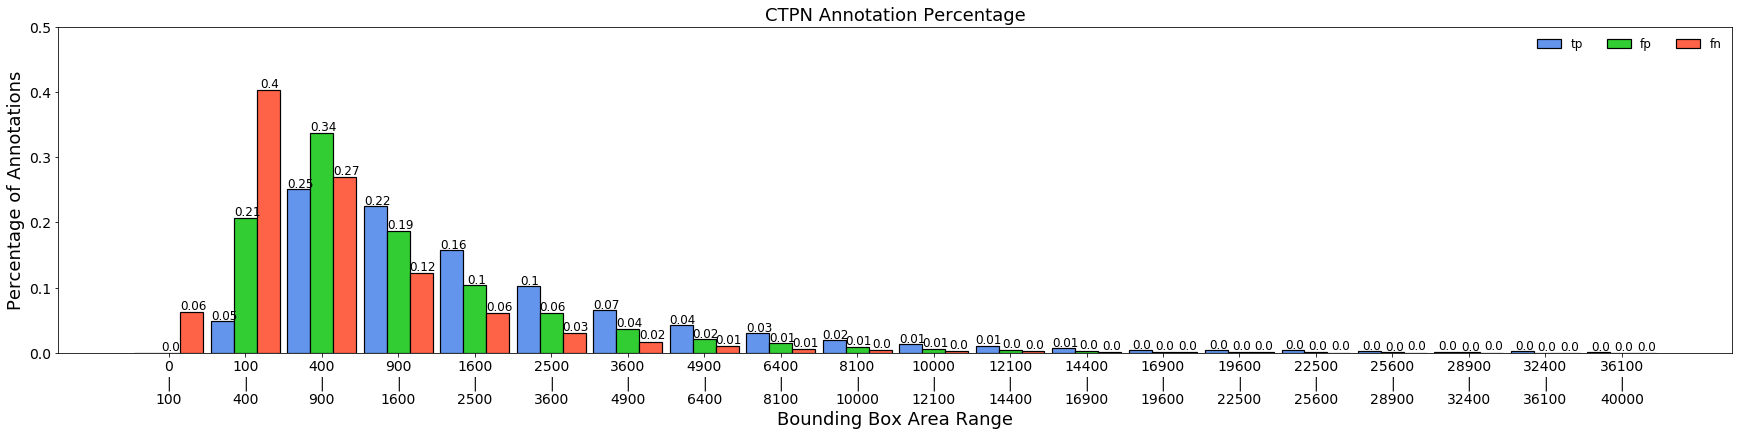

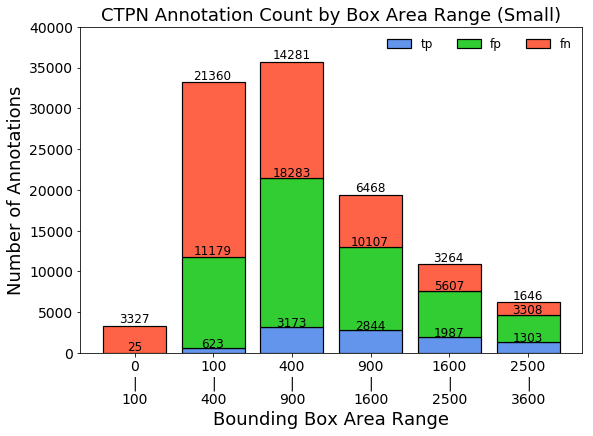

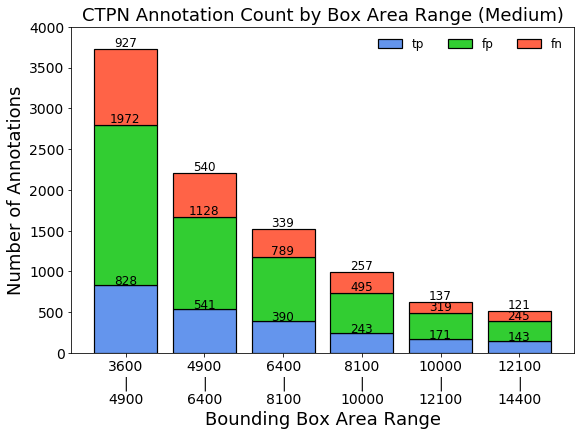

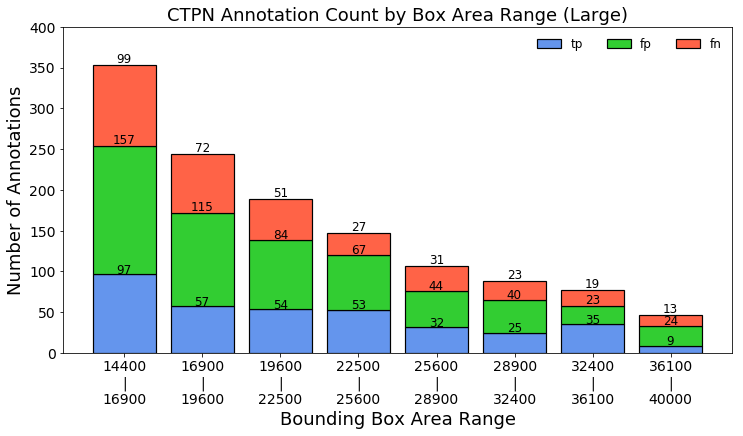

In [14]:
from matplotlib.pyplot import hist

bin_range = np.power(np.linspace(0,200,21),2).astype(np.int64)
ctpn_tp_num_annots = np.histogram(ctpn_tp_areas_list,bin_range)[0]
ctpn_fp_num_annots = np.histogram(ctpn_fp_areas_list,bin_range)[0]
ctpn_fn_num_annots = np.histogram(ctpn_fn_areas_list,bin_range)[0]
bin_label = [str(bstart) + '\n' + '|\n' + str(bend) for bstart,bend in zip(bin_range[:-1],bin_range[1:])]
uplt.plot_annot_count_3bars_horizontal(np.arange(20), 
                            [ctpn_tp_num_annots / len(ctpn_tp_areas_list), 
                                 ctpn_fp_num_annots/ len(ctpn_fp_areas_list), 
                                 ctpn_fn_num_annots/ len(ctpn_fn_areas_list)],
                            x_ticks=bin_label,
                            title='CTPN Annotation Percentage',
                            xlabel='Bounding Box Area Range',
                            ylabel='Percentage of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,0.5),
                            figsize=(30,6))
uplt.plot_annot_count_3bars_vertical(np.arange(6), 
                            [ctpn_tp_num_annots[:6], ctpn_fp_num_annots[:6], ctpn_fn_num_annots[:6]],
                            x_ticks=bin_label[:6],
                            title='CTPN Annotation Count by Box Area Range (Small)',
                            xlabel='Bounding Box Area Range',
                            ylabel='Number of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,4e4),
                            figsize=(9,6))
uplt.plot_annot_count_3bars_vertical(np.arange(6), 
                            [ctpn_tp_num_annots[6:12], ctpn_fp_num_annots[6:12], ctpn_fn_num_annots[6:12]],
                            x_ticks=bin_label[6:12],
                            title='CTPN Annotation Count by Box Area Range (Medium)',
                            xlabel='Bounding Box Area Range',
                            ylabel='Number of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,4e3),
                            figsize=(9,6))
uplt.plot_annot_count_3bars_vertical(np.arange(8), 
                            [ctpn_tp_num_annots[12:], ctpn_fp_num_annots[12:], ctpn_fn_num_annots[12:]],
                            x_ticks=bin_label[12:],
                            title='CTPN Annotation Count by Box Area Range (Large)',
                            xlabel='Bounding Box Area Range',
                            ylabel='Number of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,4e2),
                            figsize=(12,6))

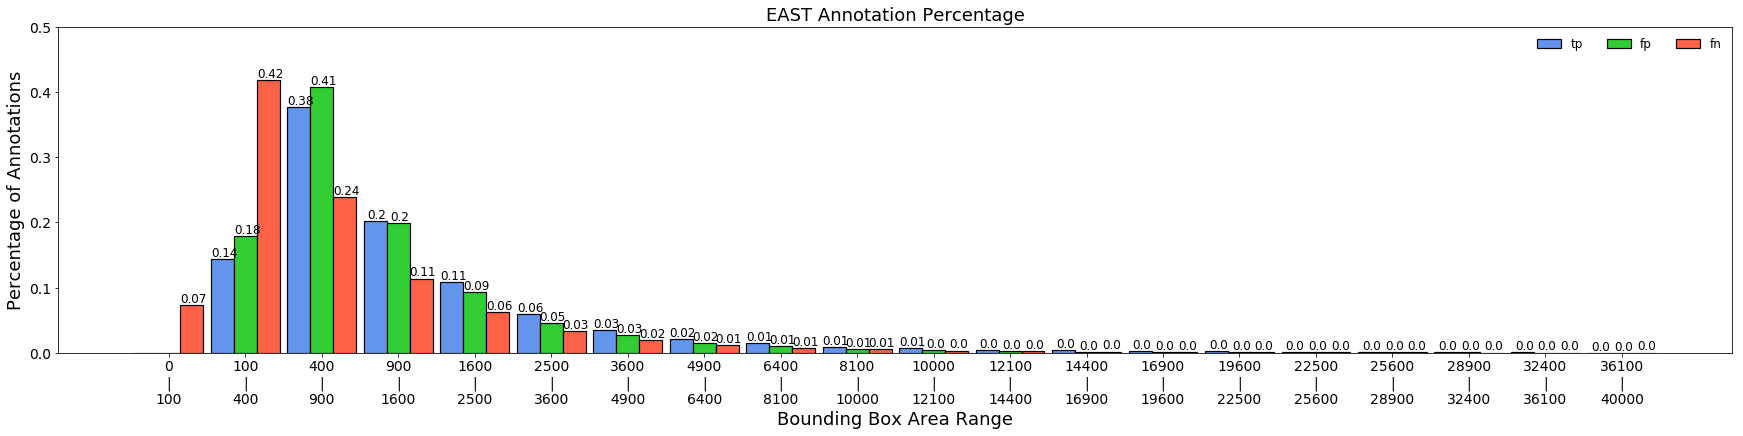

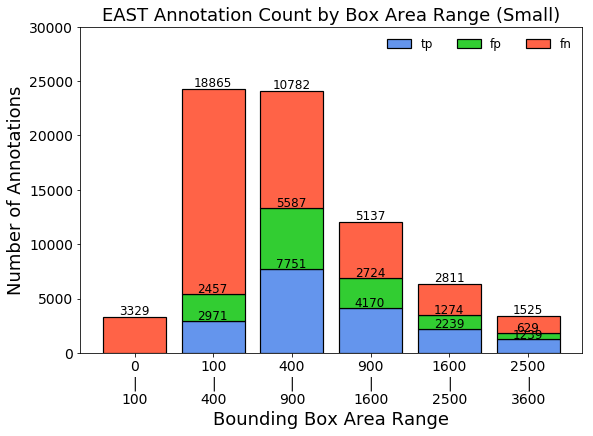

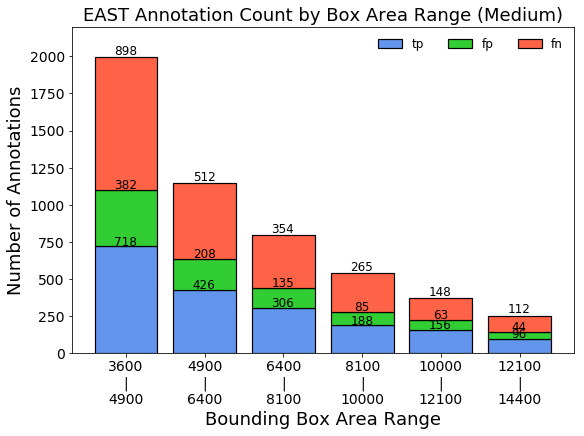

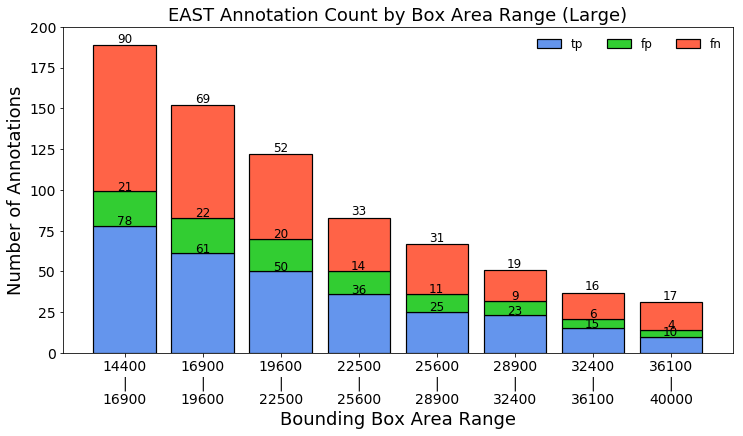

In [15]:
from matplotlib.pyplot import hist

bin_range = np.power(np.linspace(0,200,21),2).astype(np.int64)
east_tp_num_annots = np.histogram(east_tp_areas_list,bin_range)[0]
east_fp_num_annots = np.histogram(east_fp_areas_list,bin_range)[0]
east_fn_num_annots = np.histogram(east_fn_areas_list,bin_range)[0]
bin_label = [str(bstart) + '\n' + '|\n' + str(bend) for bstart,bend in zip(bin_range[:-1],bin_range[1:])]
uplt.plot_annot_count_3bars_horizontal(np.arange(20), 
                            [east_tp_num_annots / len(east_tp_areas_list), 
                                 east_fp_num_annots/ len(east_fp_areas_list), 
                                 east_fn_num_annots/ len(east_fn_areas_list)],
                            x_ticks=bin_label,
                            title='EAST Annotation Percentage',
                            xlabel='Bounding Box Area Range',
                            ylabel='Percentage of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,0.5),
                            figsize=(30,6))
uplt.plot_annot_count_3bars_vertical(np.arange(6), 
                            [east_tp_num_annots[:6], east_fp_num_annots[:6], east_fn_num_annots[:6]],
                            x_ticks=bin_label[:6],
                            title='EAST Annotation Count by Box Area Range (Small)',
                            xlabel='Bounding Box Area Range',
                            ylabel='Number of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,3e4),
                            figsize=(9,6))
uplt.plot_annot_count_3bars_vertical(np.arange(6), 
                            [east_tp_num_annots[6:12], east_fp_num_annots[6:12], east_fn_num_annots[6:12]],
                            x_ticks=bin_label[6:12],
                            title='EAST Annotation Count by Box Area Range (Medium)',
                            xlabel='Bounding Box Area Range',
                            ylabel='Number of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,22e2),
                            figsize=(9,6))
uplt.plot_annot_count_3bars_vertical(np.arange(8), 
                            [east_tp_num_annots[12:], east_fp_num_annots[12:], east_fn_num_annots[12:]],
                            x_ticks=bin_label[12:],
                            title='EAST Annotation Count by Box Area Range (Large)',
                            xlabel='Bounding Box Area Range',
                            ylabel='Number of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,2e2),
                            figsize=(12,6))

### Bounding Box Log Width-Height Ratio

In [16]:
from scipy.stats import describe

eps = 1e-05
ctpn_tp_whratio_list = []
ctpn_fp_whratio_list = []
ctpn_fn_whratio_list = []

for tp_det in detection_results_ctpn['true_positives']:
    annot = ev_ctpn.loadAnns(tp_det['eval_id'])
    ctpn_tp_whratio_list.append(np.log10((annot[0]['bbox'][2] + eps) / 
                                  (annot[0]['bbox'][3] + eps)))
    
for fp_det in detection_results_ctpn['false_positives']:
    annot = ev_ctpn.loadAnns(fp_det['eval_id'])
    ctpn_fp_whratio_list.append(np.log10((annot[0]['bbox'][2] + eps) / 
                                  (annot[0]['bbox'][3] + eps)))

for fn_det in detection_results_ctpn['false_negatives']:
    annot = gt.loadAnns(fn_det['gt_id'])
    ctpn_fn_whratio_list.append(np.log10((annot[0]['bbox'][2] + eps) / 
                                  (annot[0]['bbox'][3] + eps)))
    
ctpn_tp_whratio_list = np.array(ctpn_tp_whratio_list)
ctpn_fp_whratio_list = np.array(ctpn_fp_whratio_list)
ctpn_fn_whratio_list = np.array(ctpn_fn_whratio_list)

print("CTPN TP wh ratio describe stats")
print(describe(ctpn_tp_whratio_list))
print()

print("CTPN FP wh ratio describe stats")
print(describe(ctpn_fp_whratio_list))
print()

print("CTPN FN wh ratio describe stats")
print(describe(ctpn_fn_whratio_list))
print()

CTPN TP wh ratio describe stats
DescribeResult(nobs=12656, minmax=(-0.3052670056159742, 1.3812741417802477), mean=0.4422214231763283, variance=0.05988233465665289, skewness=-0.18730950776458877, kurtosis=0.11436155667203973)

CTPN FP wh ratio describe stats
DescribeResult(nobs=54123, minmax=(-0.3296750721100448, 1.8930208777679165), mean=0.5595069920866373, variance=0.08437396024188519, skewness=-0.05405615923702515, kurtosis=0.24532060264163302)

CTPN FN wh ratio describe stats
DescribeResult(nobs=53064, minmax=(-6.258246682456884, 6.4306405058192295), mean=0.22343709796461922, variance=0.08147301486936516, skewness=0.15558728749864037, kurtosis=18.772569281454405)



In [17]:
from scipy.stats import describe

eps = 1e-05
east_tp_whratio_list = []
east_fp_whratio_list = []
east_fn_whratio_list = []

for tp_det in detection_results_east['true_positives']:
    annot = ev_east.loadAnns(tp_det['eval_id'])
    east_tp_whratio_list.append(np.log10((annot[0]['bbox'][2] + eps) / 
                                  (annot[0]['bbox'][3] + eps)))
    
for fp_det in detection_results_east['false_positives']:
    annot = ev_east.loadAnns(fp_det['eval_id'])
    east_fp_whratio_list.append(np.log10((annot[0]['bbox'][2] + eps) / 
                                  (annot[0]['bbox'][3] + eps)))

for fn_det in detection_results_east['false_negatives']:
    annot = gt.loadAnns(fn_det['gt_id'])
    east_fn_whratio_list.append(np.log10((annot[0]['bbox'][2] + eps) / 
                                  (annot[0]['bbox'][3] + eps)))
    
east_tp_whratio_list = np.array(east_tp_whratio_list)
east_fp_whratio_list = np.array(east_fp_whratio_list)
east_fn_whratio_list = np.array(east_fn_whratio_list)

print("EAST TP wh ratio describe stats")
print(describe(east_tp_whratio_list))
print()

print("EAST FP wh ratio describe stats")
print(describe(east_fp_whratio_list))
print()

print("EAST FN wh ratio describe stats")
print(describe(east_fn_whratio_list))
print()

EAST TP wh ratio describe stats
DescribeResult(nobs=20596, minmax=(-0.8016321024188147, 1.2230875300812643), mean=0.39687892580984546, variance=0.033623406883723395, skewness=-0.2241050969634971, kurtosis=1.7057717373108403)

EAST FP wh ratio describe stats
DescribeResult(nobs=13720, minmax=(-0.8502373688482159, 1.1760910457181009), mean=0.35151973350692317, variance=0.044538888909827726, skewness=-0.8312133555492344, kurtosis=4.064016346955244)

EAST FN wh ratio describe stats
DescribeResult(nobs=45124, minmax=(-6.258246682456884, 6.4306405058192295), mean=0.18729290857153985, variance=0.08509278673236406, skewness=0.4036925577558584, kurtosis=20.419539552630816)



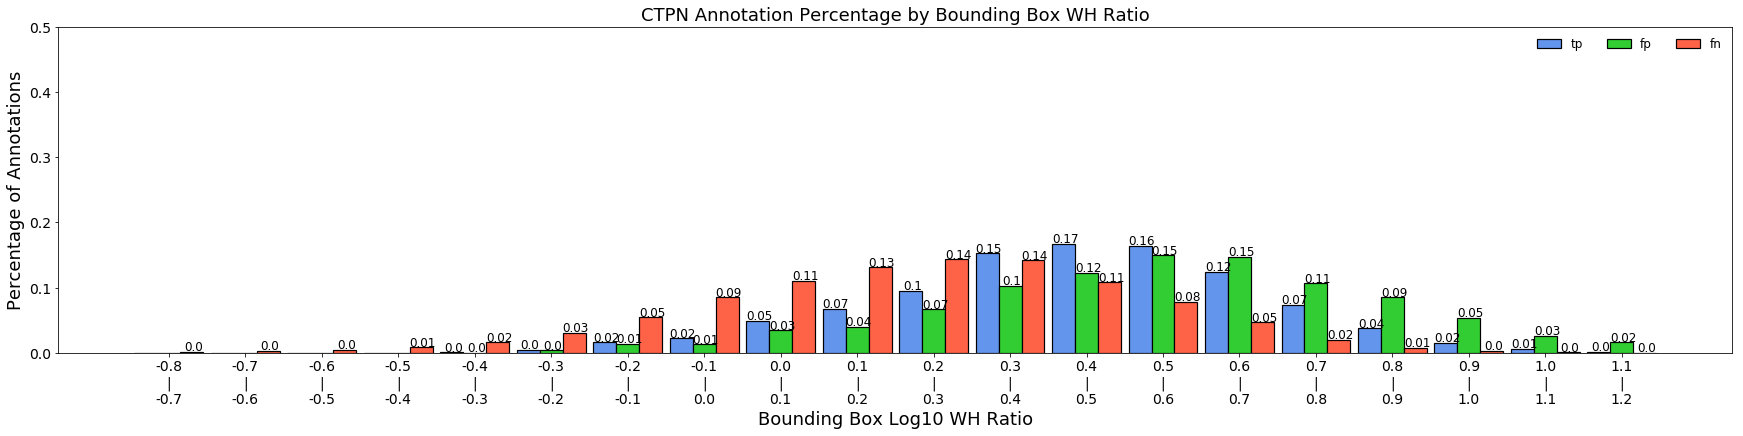

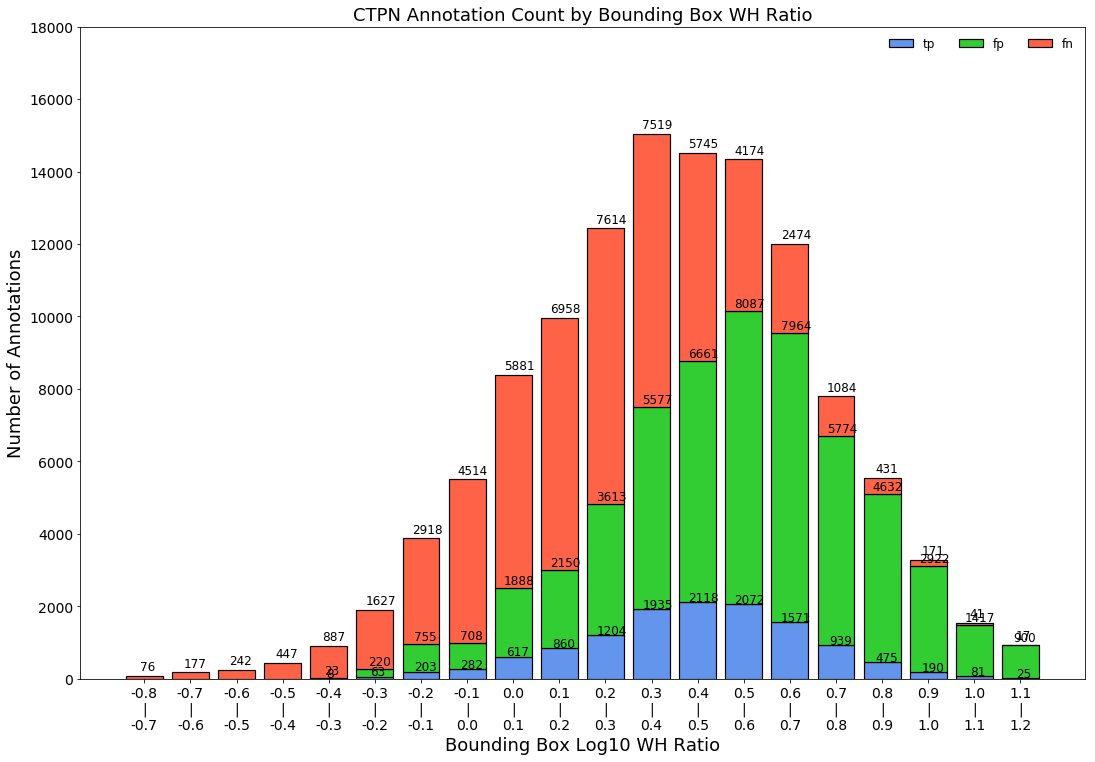

In [28]:
from matplotlib.pyplot import hist

bin_range = np.linspace(-0.8,1.2,21)
ctpn_tp_num_annots = np.histogram(ctpn_tp_whratio_list,bin_range)[0]
ctpn_fp_num_annots = np.histogram(ctpn_fp_whratio_list,bin_range)[0]
ctpn_fn_num_annots = np.histogram(ctpn_fn_whratio_list,bin_range)[0]
bin_label = [str(round(bstart,1)) + '\n' + '|\n' + str(round(bend,2)) 
             for bstart,bend in zip(bin_range[:-1],bin_range[1:])]
uplt.plot_annot_count_3bars_horizontal(np.arange(20), 
                            [ctpn_tp_num_annots / len(ctpn_tp_whratio_list), 
                                 ctpn_fp_num_annots/ len(ctpn_fp_whratio_list), 
                                 ctpn_fn_num_annots/ len(ctpn_fn_whratio_list)],
                            x_ticks=bin_label,
                            title='CTPN Annotation Percentage by Bounding Box WH Ratio',
                            xlabel='Bounding Box Log10 WH Ratio',
                            ylabel='Percentage of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,0.5),
                            figsize=(30,6))
uplt.plot_annot_count_3bars_vertical(np.arange(20), 
                            [ctpn_tp_num_annots, ctpn_fp_num_annots, ctpn_fn_num_annots],
                            x_ticks=bin_label,
                            title='CTPN Annotation Count by Bounding Box WH Ratio',
                            xlabel='Bounding Box Log10 WH Ratio',
                            ylabel='Number of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,1.8e4),
                            figsize=(18,12))

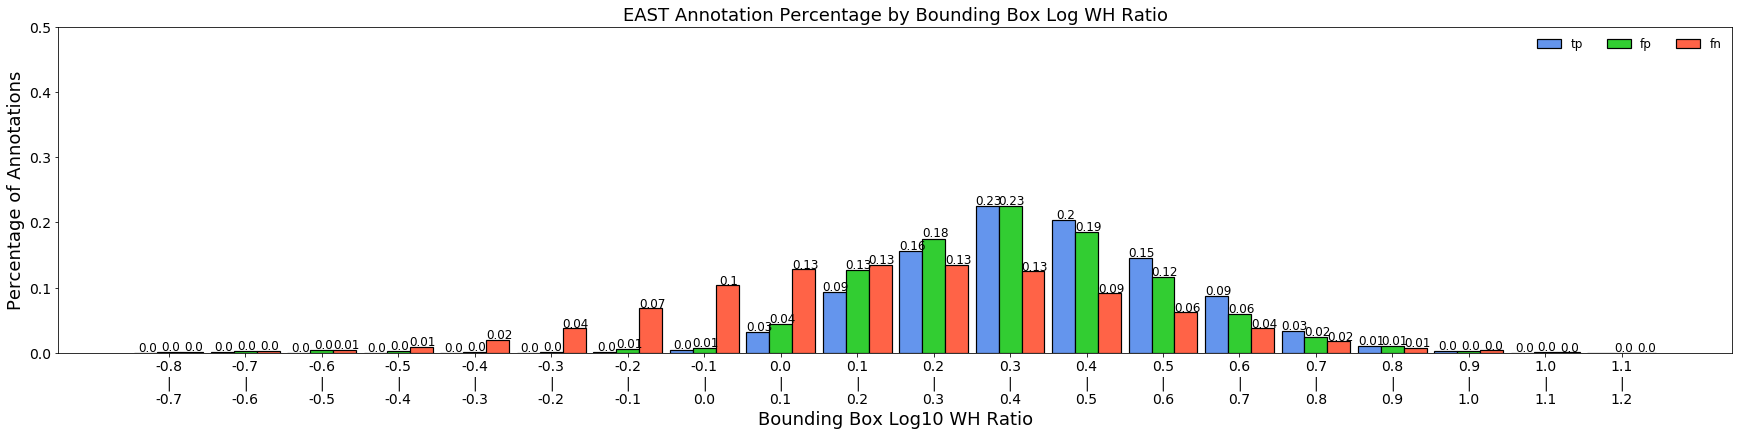

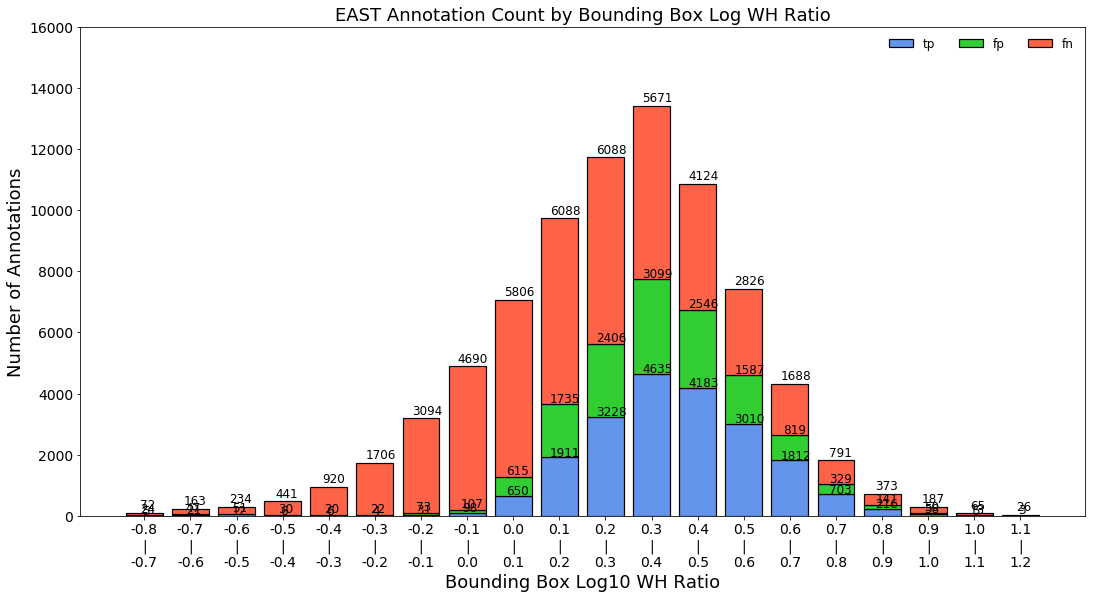

In [50]:
from matplotlib.pyplot import hist

bin_range = np.linspace(-0.8,1.2,21)
east_tp_num_annots = np.histogram(east_tp_whratio_list,bin_range)[0]
east_fp_num_annots = np.histogram(east_fp_whratio_list,bin_range)[0]
east_fn_num_annots = np.histogram(east_fn_whratio_list,bin_range)[0]
bin_label = [str(round(bstart,1)) + '\n' + '|\n' + str(round(bend,2)) 
             for bstart,bend in zip(bin_range[:-1],bin_range[1:])]
uplt.plot_annot_count_3bars_horizontal(np.arange(20), 
                            [east_tp_num_annots / len(east_tp_whratio_list), 
                                 east_fp_num_annots/ len(east_fp_whratio_list), 
                                 east_fn_num_annots/ len(east_fn_whratio_list)],
                            x_ticks=bin_label,
                            title='EAST Annotation Percentage by Bounding Box Log WH Ratio',
                            xlabel='Bounding Box Log10 WH Ratio',
                            ylabel='Percentage of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,0.5),
                            figsize=(30,6))
uplt.plot_annot_count_3bars_vertical(np.arange(20), 
                            [east_tp_num_annots, east_fp_num_annots, east_fn_num_annots],
                            x_ticks=bin_label,
                            title='EAST Annotation Count by Bounding Box Log WH Ratio',
                            xlabel='Bounding Box Log10 WH Ratio',
                            ylabel='Number of Annotations',
                            legends=['tp','fp','fn'],
                            ylim=(0,1.6e4),
                            figsize=(18,9))

## Advanced Evaluation

In [35]:
def fill_mask_from_annots(annots, zero_mask):
    for annot in annots:
        if 'legibility' not in annot.keys() or 'class' not in annot.keys() or \
                annot['legibility'] != 'legible' or annot['class'] != 'machine printed':
            pass
        box_x = int(round(annot['bbox'][0]))
        box_y = int(round(annot['bbox'][1]))
        box_width = int(round(annot['bbox'][2]))
        box_height = int(round(annot['bbox'][3]))
        # replace the area in the mask covered by the bounding box with 1
        zero_mask[box_x:box_x+box_width, box_y:box_y+box_height] = 1
    return zero_mask

def get_jaccard_score_from_annots(mask1, mask2):
    intersect_mask = np.logical_and(mask1 == 1, mask2 == 1)
    union_mask = np.logical_or(mask1 == 1, mask2 == 1)
    intersect_count = np.sum(intersect_mask)
    union_count = np.sum(union_mask)
    return (intersect_count + 1) / (union_count + 1)

In [38]:
ctpn_image_score = {}
east_image_score = {}
for image_id in valid_image_ids:
    image_stat = gt.loadImgs(image_id)[0]
    gt_annots = gt.loadAnns(gt.getAnnIds(imgIds=image_id))
    ev_ctpn_annots = ev_ctpn.loadAnns(ev_ctpn.getAnnIds(imgIds=image_id))
    ev_east_annots = ev_east.loadAnns(ev_east.getAnnIds(imgIds=image_id))
    # Pass all cases without ground truth
    if len(gt_annots) == 0:
        pass
    image_weight = image_stat['width']
    image_height = image_stat['height']
    # Create a zero mask with the size of the image
    gt_mask = fill_mask_from_annots(gt_annots, np.zeros((image_weight,image_height)))
    # Do the same with the evaluation mask
    ev_ctpn_mask = fill_mask_from_annots(ev_ctpn_annots, np.zeros((image_weight,image_height)))
    # And count teh score
    ctpn_image_score[image_id] = get_jaccard_score_from_annots(gt_mask, ev_ctpn_mask)
    # Repeat with EAST
    ev_east_mask = fill_mask_from_annots(ev_east_annots, np.zeros((image_weight,image_height)))
    east_image_score[image_id] = get_jaccard_score_from_annots(gt_mask, ev_east_mask)
#     print(ctpn_image_score[image_id])
#     print(east_image_score[image_id])
#     break

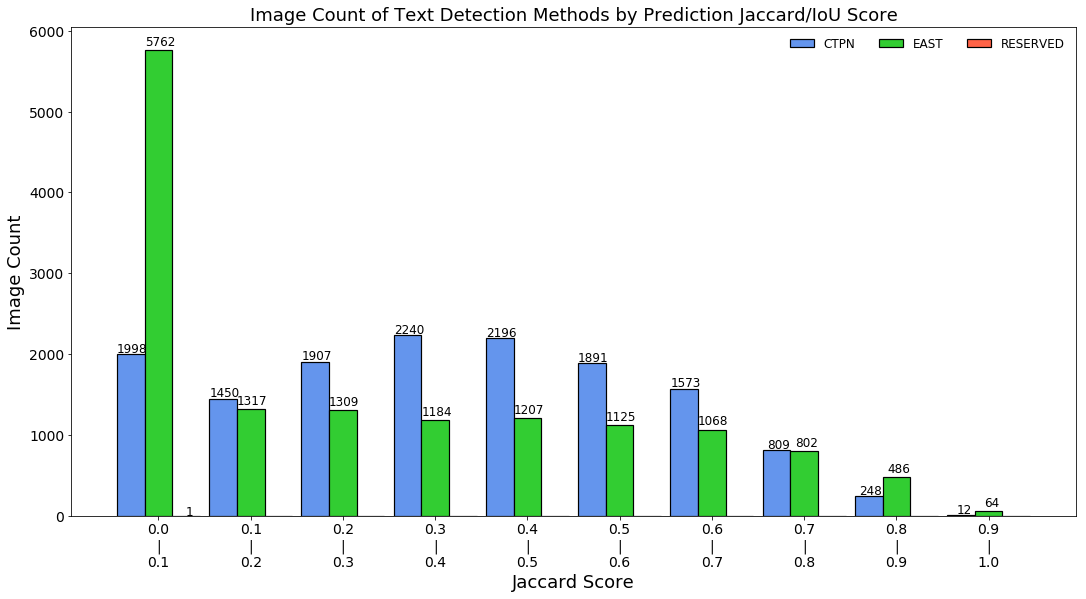

In [49]:
bin_range = np.linspace(0,1,11)
ctpn_score_count = np.histogram(list(ctpn_image_score.values()), bins=bin_range)[0]
east_score_count = np.histogram(list(east_image_score.values()), bins=bin_range)[0]
dummy_score_count = np.histogram([0], bins=bin_range)[0]
bin_label = [str(round(bstart,2)) + '\n' + '|\n' + str(round(bend,2)) 
             for bstart,bend in zip(bin_range[:-1],bin_range[1:])]
uplt.plot_annot_count_3bars_horizontal(np.arange(10), 
                                [ctpn_score_count,east_score_count,dummy_score_count],
                                legends=['CTPN','EAST','RESERVED'],
                                x_ticks=bin_label,
                                title='Image Count of Text Detection Methods by Prediction Jaccard/IoU Score',
                                xlabel='Jaccard Score',
                                ylabel='Image Count',
                                figsize=(18,9))

In [90]:
from importlib import reload 
reload(uplt)

<module 'util.plotting' from '/home/rudi/Documents/Notebook/Data_Anal/cocotext_analysis/util/plotting.py'>